# Pix2Pix를 사용해 Segmentation map으로 도로 이미지 만들기

1. 데이터 준비
2. Generator 구성
3. Discriminator 구성하기
4. Generator와 Discriminator 학습
5. 모델 테스트


#### cgan이란?

잘 학습된 GAN을 이용해 실제 이미지를 생성할 때 원하는 종류의 이미지를 바로 생성해 내지 못한다.

다시 말해서 일반적인 GAN과 같은 unconditioned generative model은 내가 생성하고자 하는 데이터에 대해 제어하기 힘들었다.

따라서, unconditioned 모델을 condition해서 특정 조건을 준다.

특정 조건을 목적함수에서 확인할 수 있다. D(x)와 G(z)가 각각 D(x∣y), G(z∣y)로 바뀌었는데 y가 바로 특정 조건에 해당된다. 

 ==>  (여기서 x는 실제 데이터, z는 노이즈)
 ==> 여기서 y는 레이블 정보이며, 일반적으로 one-hot 벡터를 입력으로 넣는다.


#### pix2pix란?
기존 노이즈 입력을 이미지로 변환하는 일반적인 GAN이 아니라, 이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델

Conditional Adversarial Networks로 Image-to-Image Translation을 수행한다.

즉, 이미지에 간 변환이 이루어진다는 것이다.



#### pix2pix의 U-Net generator 구조란?

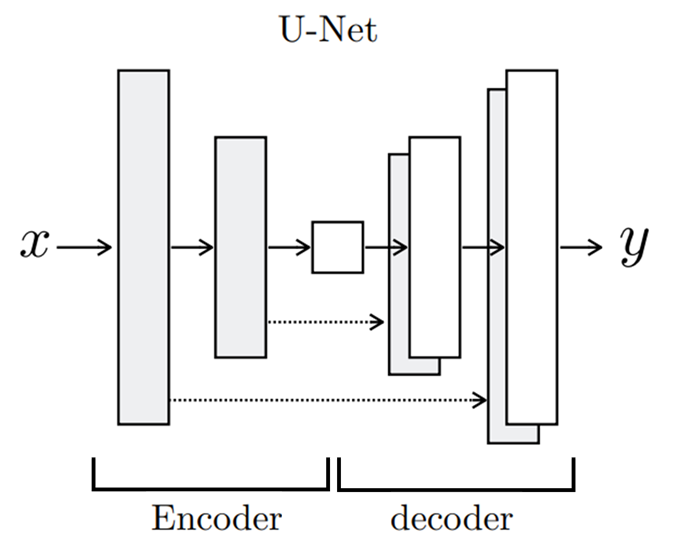

기존 generator 구조와의 차이점: 이어마다 Encoder와 Decoder가 연결(skip connection)되어 있다는 것

skip connection 이용하는 이유? Decoder가 변환된 이미지를 더 잘 생성하도록 Encoder로부터 더 많은 추가 정보를 이용하는 방법이기 때문이다.



#### pix2pix의 loss function?

출력된 이미지와 실제 이미지의 차이로 L2(MSE), L1(MAE) 같은 손실을 계산한 후 이를 역전파하여 네트워크를 Generator가 학습시킨다면?
 ==> Generator는 단순히 이미지의 평균적인 손실만을 줄이고자 파라미터를 학습하기 때문에 이미지가 흐릿해진다.


cGAN과 같은 GAN 기반의 학습 방법만 사용한다면?
 ==> 비교적 선명하고 세밀한 정보를 표현할 수 있다. iscriminator를 잘 속이려면 Generator가 (Ground truth라고 쓰여진 이미지같이) 진짜 같은 이미지를 만들어야 하기 때문이다. 그러나, 세밀한 그 정보가 원본과 동떨어진 결과 값일 수가 있다. 제한된 정보로 세밀하게 표현하려고 하기 때문이다.


 - 따라서, Ground Truth와 근접한 정보(세밀한 동시에 정확한 정보)를 표현하기 위해 L1손실과 GAN 손실을 함께 사용하자!
 
 
 
 #### pix2pix의 discriminator? patchGAN
 
기존 DCGAN의 Discriminator: 생성된 가짜이미지 혹은 진짜이미지를 하나씩 입력받아 convolution 레이어를 이용해 점점 크기를 줄여나가면서, 최종적으로 하나의 이미지에 대해 하나의 확률값을 출력


pix2pix의 Discriminator: 하나의 전체 이미지에 대해 하나의 확률값이 아닌 여러개의 확률 값을 도출하자는 아이디어 https://arxiv.org/pdf/1611.07004.pdf



일반적으로 이미지에서 거리가 먼 두 픽셀은 서로 연관성이 거의 없기 때문에 특정 크기를 가진 일부 영역에 대해서 세부적으로 진짜/가짜를 판별하는 것이 Generator로 하여금 더 진짜 같은 이미지를 만들도록 하는 방법


patch 크기 정하는 tip:
전체 pixel 수를 n n이라고 가정할 때, patch 크기를 n n으로 설정하면, 전체 이미지에 대해 하나의 확률값을 구하는 것이므로 patchGAN을 사용하는 의미가 사라진다.
반면, patch 크기를 너무 작게 잡아주면 너무 작은 receptive field를 가지고 확률값을 구하기 때문에 출력 이미지가 선명하지 않다.


따라서, patch의 크기를 너무 작지도, 크지도 않게 설정해주도록 한다.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model

In [5]:
data_path = os.getenv('HOME')+'/aiffel/EXP_19_sketcher/conditional_generation/data/cityscapes/'
train_data_path = data_path+'train/'
val_data_path = data_path+'val/'


print("number of train examples :", len(os.listdir(train_data_path)))
print("number of validation examples :", len(os.listdir(val_data_path)))

number of train examples : 1000
number of validation examples : 5


(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)


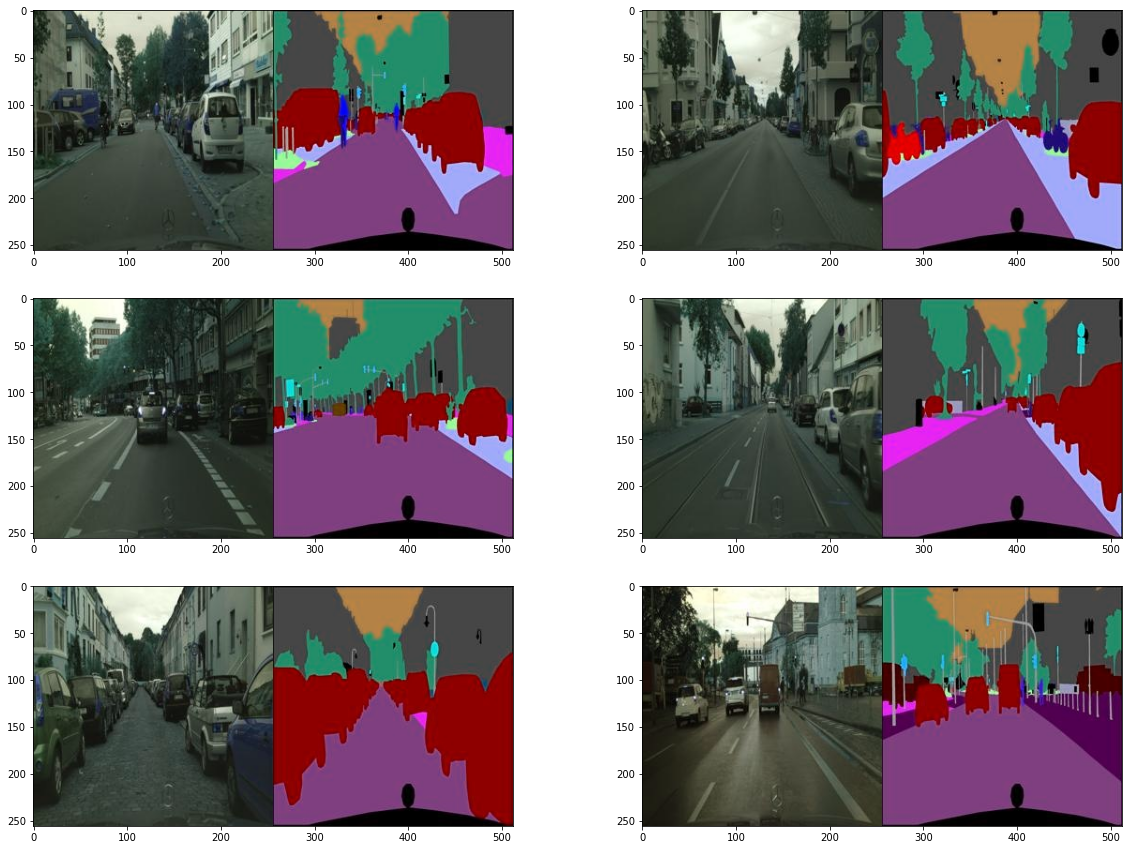

In [11]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_data_path + os.listdir(train_data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)
    
    #이미지 크기 확인
    print(img.shape)

이미지 크기가 (256, 512, 3)이므로 모델 학습에 사용할 데이터는 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용할 것.

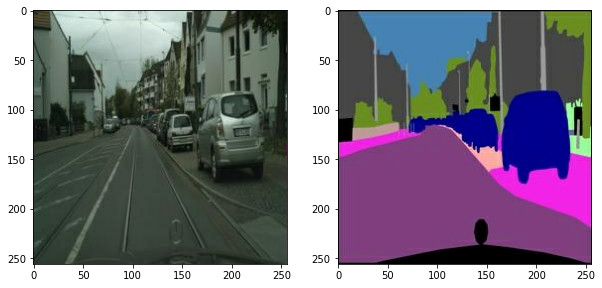

In [13]:
# 이미지 픽셀 값을 -1~1로 정규화
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = train_data_path + os.listdir(train_data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## Augmentation 적용
학습 데이터는 1000개 뿐이므로 데이터의 다양성을 높이기 위해 augmentation 방법 적용함.
apply_augmentation 함수
두 이미지가 채널 축으로 연결되고 이 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼 적용됨.
위의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라내고 이 결과를 50% 확률로 가로로 뒤집음.
위의 결과를 50% 확률로 세로로 뒤집고 다시 50%의 확률로 회전시킴.

In [14]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

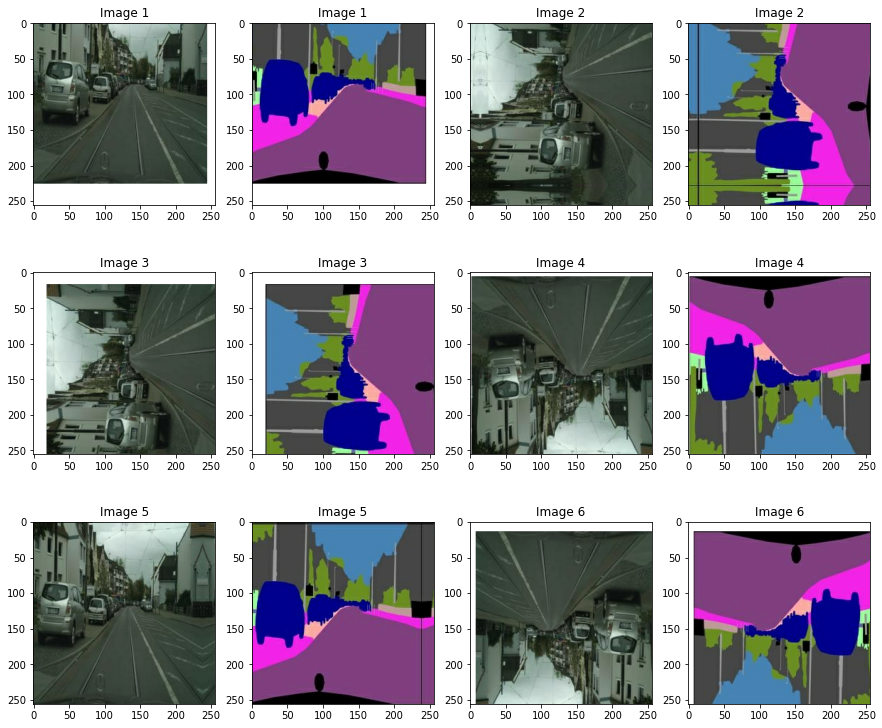

In [16]:
#데이터에 augmentation 적용이 되었는지 확인
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

대부분의 경우 train dataset의 수가 클수록 모델의 학습 후 성능이 개선된다.

이 경우 train dataset의 수가 1000개에 불과하므로 데이터셋이 다소 부족한 감이 있다.

train dataset의 수를 늘려주는게 이상적이겠지만 dataset을 확보하는 데에 많은 비용과 시간이 들어간다.

이때 가장 현실적인 방법이 augmentation을 통해 가지고 있는 dataset에 변형을 주어 dataset의 크기를 늘리는 것이다.

이번에 선택한 augmentation 방법은 이미지 일부를 자르고, 90도를 기준으로 회전을 여러번하는 것을 혼합하는 방식이다.

crop: image 1,4,5의 흰 공백을 통해 이미지가 잘렸음을 확인할 수 있다.

rotation:
 - image1: 양의 방향으로 90도
 - image3: 음의 방향으로 90도
 - image5: 양의 방향으로 90도
 - image6: 양/음의 방향으로 180도


이번 익스플로레이션에서는 crop과 rotation을 통한 positional augmentation을 도입했지만, 더 나아가 밝기, 대비 등을 이용한 color augmentation을 수행해볼 수도 있다.

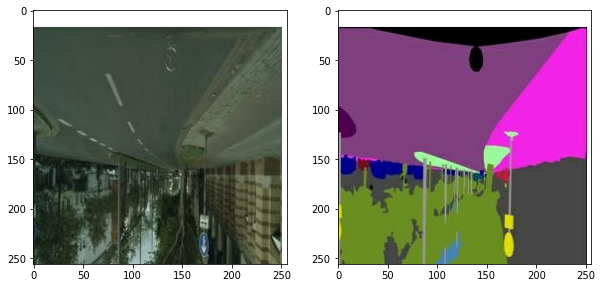

In [17]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(train_data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## Pix2pix

#### Generator 구성

Encoder와 Decoder 사이를 skip connection으로 연결한 U-Net Generator 사용.

Encoder : 블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨.

Decoder : 블록을 통과할수록 (width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 출력됨.

In [18]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        # n_filters = 사용할 필터의 개수, BatchNorm 사용 여부
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)
    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

### UNetGenerator

In [19]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
        # Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, 
        # Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아닙니다.
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
        # Skip connection은 Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, 
        # Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는.. 등 대칭을 이룹니다. 
        # features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 
        # 이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결합니다.
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [20]:
#U-Net 구조 Generator 내부의 각 출력이 적절한지 확인
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

# 3. Discriminator 구성하기
두 개의 (256,256,3) 크기 입력으로 최종 (30,30,1) 출력을 만듦.

In [21]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [22]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

# 모델 학습

일반적인 GAN의 손실함수에 L1을 추가로 이용해서 가장 실제에 가까운 이미지를 생성하자
손실 함수

#### 손실함수

In [23]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

### optimizer

In [24]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정

In [26]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
EPOCHS = 32 

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 200회 반복마다 손실을 출력합니다.
        if (i+1) % 200 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")